# 7. Predicting Personality Index

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score

from scipy import stats

Functionals

In [ ]:
import random

def predict_result(classifier, trainX, trainY, valX, valY, a, metric='corr', ret_pred=False):
    clf        = classifier(alpha=a)
    clf.fit(trainX, trainY)
    prediction = clf.predict(valX)

    
    if metric == 'corr':
        res = stats.pearsonr(prediction, valY).statistic
    else:
        res = clf.score(valX,valY)

    if ret_pred:
        return res, clf.coef_ , prediction
    else:
        return res, clf.coef_
    
# find best parameter for all folds
def predict_fold(classifier, X, y, splits, a, kfold, metric='corr', ret_pred=False):
    fold_val = []

    m, n     = X.shape
    coefs    = np.zeros((kfold, m, n))
    predictions = np.zeros((kfold, len(splits[0])))
    for j in range(kfold):
        val_idx   = splits[j]
        train_idx = np.array(list(set(np.arange(len(psyscore))) - set(val_idx)))

        trainX, valX    = X[train_idx], X[val_idx] 
        trainY, valY    = y[train_idx], y[val_idx]

        if ret_pred:
            res, coef, prediction =  predict_result(classifier, trainX, trainY, valX, valY, a, metric=metric, ret_pred=ret_pred)
        else:
            res, coef  =  predict_result(classifier, trainX, trainY, valX, valY, a, metric=metric, ret_pred=ret_pred)

        coefs[j]       = coef
        predictions[j] = prediction
        
        fold_val.append(res)
    
    coefs        = coefs.mean(axis=0)
    avg_fold_val = fold_val
    
    if ret_pred:
        return avg_fold_val, coefs, predictions
    else:
        return avg_fold_val, coefs 
    


# find best parameter a specific pair of
# the issue is we have a overfitting problem, the solutions are not necessarily found, 
# and so we consider a solution to have a postiive R2 values on validaiton
def combination_predict(classifier, hparam_range, X, y, kfold, metric='corr', rd_state=10):
    np.random.seed(rd_state)
    # kfold needs to divisor of 30
    fold_results = []

    # k-fold splits
    splits    = np.random.choice(np.arange(len(y)),replace=False, size=(kfold,30//kfold))

    for j in range(kfold):
        # reset for this fold the best correlation search within the hyper parameter ranges
        best_res  = -1
        best_coef = None
        best_pred = None
        best_corr = -1

        val_idx   = splits[j]
        train_idx = np.array(list(set(np.arange(len(X))) - set(val_idx)))

        trainX, valX    = X[train_idx], X[val_idx] 
        trainY, valY    = y[train_idx], y[val_idx]

        for a in hparam_range:
            res, coef, prediction =  predict_result(classifier, trainX, trainY, valX, valY, a, metric=metric, ret_pred=True)

            if res > best_res:
                best_res  = res
                best_coef = coef
                best_pred = prediction
                best_corr = stats.pearsonr(prediction, valY).statistic
                
        fold_results.append([best_res, best_coef, best_pred, valY, best_corr])
    
    return fold_results

def sample_solution(classifier, hparam_range, X, y, kfold, nrepeat, null=False, metric='corr', rd_state=10):
    # kfold needs to divisor of 30
    np.random.seed(rd_state)
    fold_results = []
    for k in range(nrepeat):

        # if null distribution then shuffle y
        if null:
            sy = deepcopy(y)
            np.random.shuffle(sy)
        else:
            sy = deepcopy(y)
        # k-fold splits included
        fold_p = combination_predict(classifier, hparam_range, 
                                            X, sy, kfold, metric=metric, rd_state=k)
        best_res  = np.asarray(fold_p)[:,0]
        best_coef = np.asarray(fold_p)[:,1]
        best_corr = np.asarray(fold_p)[:,-1]    
        for b in range(len(best_res)):
            if best_res[b] > 0:
                fold_results.append([best_res[b], best_coef[b], best_corr[b]])
    
    return fold_results

## Description

We predict personality index from gradients

GOAL: Predicting personality index from gradients

## Table of Contents

- [On Static Gradients](#staticgrad)



### Loading

In [3]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="staticgrad"></a>
## On Static Gradients

#### Visual difference

In [4]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad400.pkl')
subjects     = list(subject_grad.keys())
subjects     = list(subject_grad.keys())
regions      = list(index2region.keys())

L            = [subject_grad[s][:,:2] for s in subjects]
aligned, _ , score = procrustes_align(L)
subject_grad = {subjects[i]: aligned[i] for i in range(len(subjects))}

feat     = existing_psy[0]
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
order    = np.argsort(psyscore)

# for Display
G1,G2,coloring = [],[],[]
N, ncoloring   = [], []
gradients    = np.asarray([subject_grad[s] for s in subjects])
for i in order:
    G1       += list(gradients[i][:,0])
    G2       += list(gradients[i][:,1])
    N.append(np.linalg.norm(gradients[i][:,:2], axis=1))
    coloring += [psyscore[i]] * 400
    ncoloring.append([psyscore[i]] * 400)
N = np.asarray(N)
ncoloring = np.asarray(ncoloring)

Text(25.22222222222222, 0.5, 'G2')

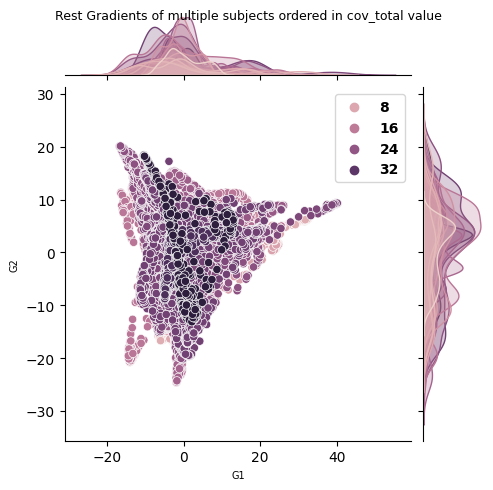

In [5]:
tmp_df = {"G1": G1 , "G2": G2, feat: coloring}

ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue=feat, height=5)
ax.fig.suptitle("Rest Gradients of multiple subjects ordered in {} value".format(feat), size=9)
legend_properties = {'weight':'bold','size':10}
ax.ax_joint.legend(prop=legend_properties,loc='upper right')
ax.ax_joint.set_xlabel('G1', size=7)
ax.ax_joint.set_ylabel('G2', size=7)

In [7]:
# correlation of first 5 gradients per parcel value with personality index
gradpsycorr = np.zeros((15,gradients.shape[1]))
for i in range(15):
    feat = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    
    for k in range(gradients.shape[1]):
        tmp1 = zscore(gradients[:,k,0])
        tmp2 = zscore(np.array(psyscore))
        corr = stats.pearsonr(tmp1, tmp2).statistic
        gradpsycorr[i][k] = corr

In [ ]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()


mask = labeling != 0
grad = [None] * 15
for i in range(15):
    # map the gradient to the parcels
    grad[i] = map_to_labels(gradpsycorr[i], labeling, mask=mask, fill=np.nan)

print('First gradient')
plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='bwr',
                 color_bar=True, label_text=existing_psy, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)

First gradient


### Regress / Predictive

#### Loadings

In [6]:
# Loading REST gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad400.pkl')
subjects     = list(subject_grad.keys())

subjects_order = list(subject_grad.keys())
regions        = list(index2region.keys())
print(subjects_order)

L            = [subject_grad[s] for s in subjects_order]
aligned, _ , score = procrustes_align(L, n_iter=10000, tol=1e-10)
gradients_rest     = np.asarray(deepcopy(aligned))

# Loading Supermovie gradients 
subject_grad = load('./resources/static_grad/individual_level/SUPERMOVIE_grad400.pkl')

L            = [subject_grad[s] for s in subjects_order]
aligned, _ , score = procrustes_align(L, n_iter=10000, tol=1e-10)
gradients_movie    = np.asarray(deepcopy(aligned))

['S17', 'S02', 'S05', 'S10', 'S11', 'S04', 'S19', 'S03', 'S16', 'S01', 'S14', 'S09', 'S13', 'S06', 'S07', 'S08', 'S15', 'S29', 'S21', 'S26', 'S27', 'S32', 'S20', 'S28', 'S22', 'S25', 'S30', 'S31', 'S24', 'S23']


#### Model Visualization

In [26]:
order_fixed = np.arange(30)
np.random.shuffle(order_fixed)

Movie based prediction

In [14]:
# initial statistic
np.random.seed(93)
kfold         = 3
lbd, rbd      = -5, 1
lambdas_lasso = np.logspace(lbd,rbd,50)
A             = gradients_movie.reshape(30,-1)

feat      = existing_psy[4]
psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
psyscore  = np.array(psyscore)

BP_movie = []
for i in tqdm(range(100)):
    results = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    BP_movie.append(results)
    
# null statistic    
null_BP_movie = []
for i in tqdm(range(100)):
    psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore  = np.array(psyscore)
    np.random.shuffle(psyscore)
    results   = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    null_BP_movie.append(results)    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(BP_movie)[:,:,0] > 0).sum(axis=1)==3)[0]))
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(null_BP_movie)[:,:,0] > 0).sum(axis=1)==3)[0]))

Good R^2 fit on all folds repeats [ 1  2  3  5  7  9 10 11 12 18 19 21 24 26 28 29 30 31 32 33 36 41 42 43
 44 45 46 48 49 50 52 54 57 61 64 67 68 70 73 74 77 79 80 81 82 83 84 86
 87 88 92 93 95 96]
Good R^2 fit on all folds repeats [ 2  6  8  9 14 20 42 44 62 76 88]


Text(0, 0.5, 'personality index value')

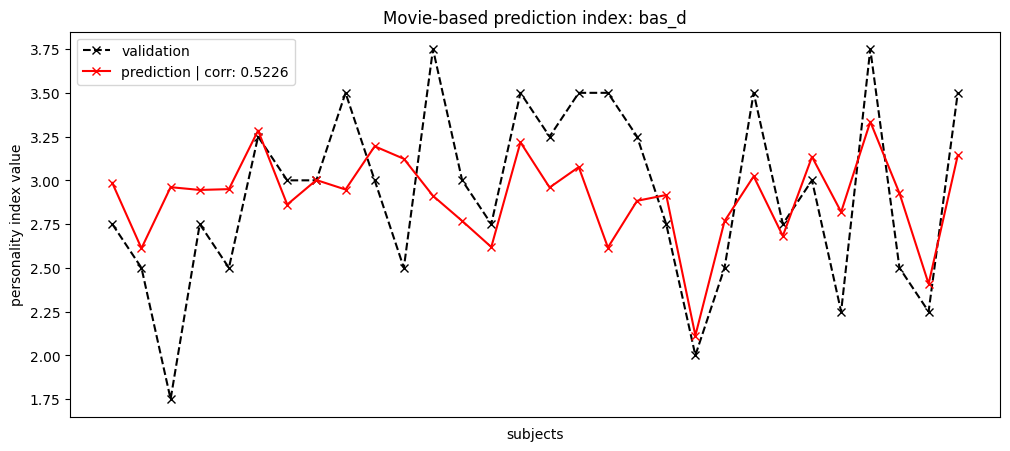

In [32]:
tmp1 = np.concatenate(np.asarray(BP_movie[5])[:,3])
tmp2 = np.concatenate(np.asarray(BP_movie[5])[:,2])
tmp3 = np.concatenate(np.asarray(null_BP_movie[11])[:,3])
tmp4 = np.concatenate(np.asarray(null_BP_movie[11])[:,2])

tmpcorr1 = pearson_correlation(tmp1,tmp2)
tmpcorr2 = pearson_correlation(tmp3,tmp4)

fig = plt.figure(figsize=(12,5))
ax  = fig.add_subplot(111)

plt.title('Movie-based prediction index: {}'.format(feat))

plt.plot(tmp1[np.argsort(tmp1)[order_fixed]], '--x', label='validation', c='k')
plt.plot(tmp2[np.argsort(tmp1)[order_fixed]], '-x', label='prediction | corr: {}'.format(round(tmpcorr1,4)), c='r')
# plt.plot(tmp3, '--x', label='validation 2', c='g')
# plt.plot(tmp4, '--x', label='prediction null | corr: {}'.format(round(tmpcorr2,4)))
plt.legend()

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_xlabel('subjects')
ax.set_ylabel('personality index value')

Rest based prediction

In [11]:
np.random.seed(93)
kfold         = 3
lbd, rbd      = -5, 1
lambdas_lasso = np.logspace(lbd,rbd,50)
A             = gradients_rest.reshape(30,-1)

feat      = existing_psy[4]
psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
psyscore  = np.array(psyscore)

# initial statistic
BP_rest = []
for i in tqdm(range(100)):
    results = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    BP_rest.append(results)
    
# null statistic    
null_BP_rest = []
for i in tqdm(range(100)):
    psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore  = np.array(psyscore)
    np.random.shuffle(psyscore)
    results   = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    null_BP_rest.append(results)    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(BP_rest)[:,:,0] > 0).sum(axis=1)==3)[0]))
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(null_BP_rest)[:,:,0] > 0).sum(axis=1)==3)[0]))

Good R^2 fit on all folds repeats [ 5  7 18 19 23 35 41 50 69 86 87]
Good R^2 fit on all folds repeats [ 5 31 56 61 62 65]


Text(0, 0.5, 'personality index value')

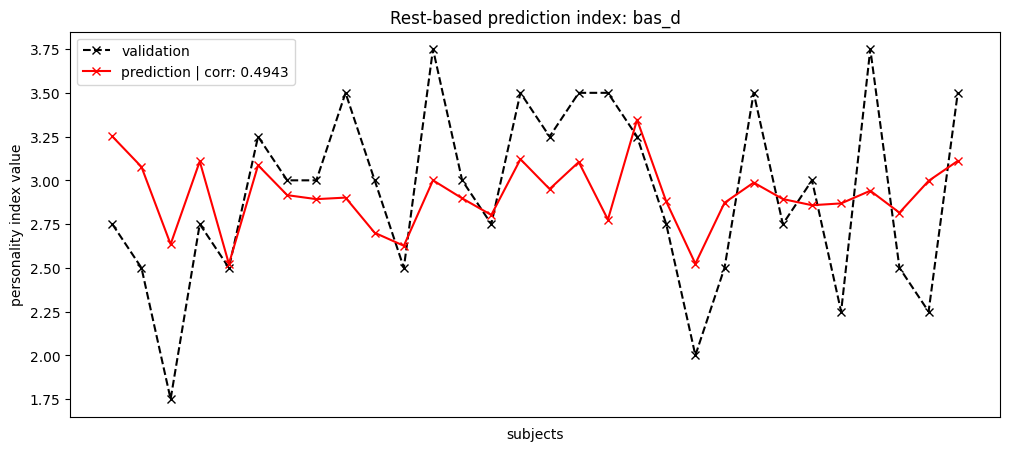

In [31]:
tmp1 = np.concatenate(np.asarray(BP_rest[87])[:,3])
tmp2 = np.concatenate(np.asarray(BP_rest[87])[:,2])
tmp3 = np.concatenate(np.asarray(null_BP_rest[78])[:,3])
tmp4 = np.concatenate(np.asarray(null_BP_rest[78])[:,2])


tmpcorr1 = pearson_correlation(tmp1,tmp2)
tmpcorr2 = pearson_correlation(tmp3,tmp4)

fig = plt.figure(figsize=(12,5))
ax  = fig.add_subplot(111)

plt.title('Rest-based prediction index: {}'.format(feat))

plt.plot(tmp1[np.argsort(tmp1)[order_fixed]], '--x', label='validation', c='k')
plt.plot(tmp2[np.argsort(tmp1)[order_fixed]], '-x', label='prediction | corr: {}'.format(round(tmpcorr1,4)), c='r')
# plt.plot(tmp3, '--x', label='prediction null | corr: {}'.format(round(tmpcorr2,4)))
plt.legend()

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_xlabel('subjects')
ax.set_ylabel('personality index value')

In [79]:
# save('./resources/tmp_ress/bp_movie.pkl', BP_movie)
# save('./resources/tmp_ress/bp_rest.pkl', BP_rest)

#### Lasso on Full gradients (3 gradients) with k-fold

##### With Movie

In [33]:
lbd,rbd = -5,1
lambdas_lasso = np.logspace(lbd,rbd,20)

In [34]:
# for k in logsnull.keys():
#     print(k)
#     print(round(np.nanmean(logsnull[k][0]),3), round(np.nanmean(logs[k][0]),3))
#     print(len(logsnull[k][0]), len(logs[k][0]))
#     print(round(np.nanmean(logsnull[k][2]),3), round(np.nanmean(logs[k][2]),3))
#     print()

In [36]:
np.random.seed(10)

logs_movie     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull_movie = {existing_psy[i]: [] for i in range(len(existing_psy))}
A        = gradients_movie.reshape(30,-1)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, metric='R2', rd_state=i)
    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logs_movie[feat]  = best_res, best_coeffs, best_corrs

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, null=True, metric='R2', rd_state=i)

    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logsnull_movie[feat] = best_res, best_coeffs, best_corrs

  0%|          | 0/15 [00:00<?, ?it/s]

In [38]:
row = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r', 
        'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row:
    folds = logs_movie[r][2]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(folds)
    
    foldsN = logsnull_movie[r][2]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(foldsN)
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx']     += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx']     += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)

In [39]:
pred_distrib['null'] = 0
null_distrib['null'] = 1

  0%|          | 0/15 [00:00<?, ?it/s]

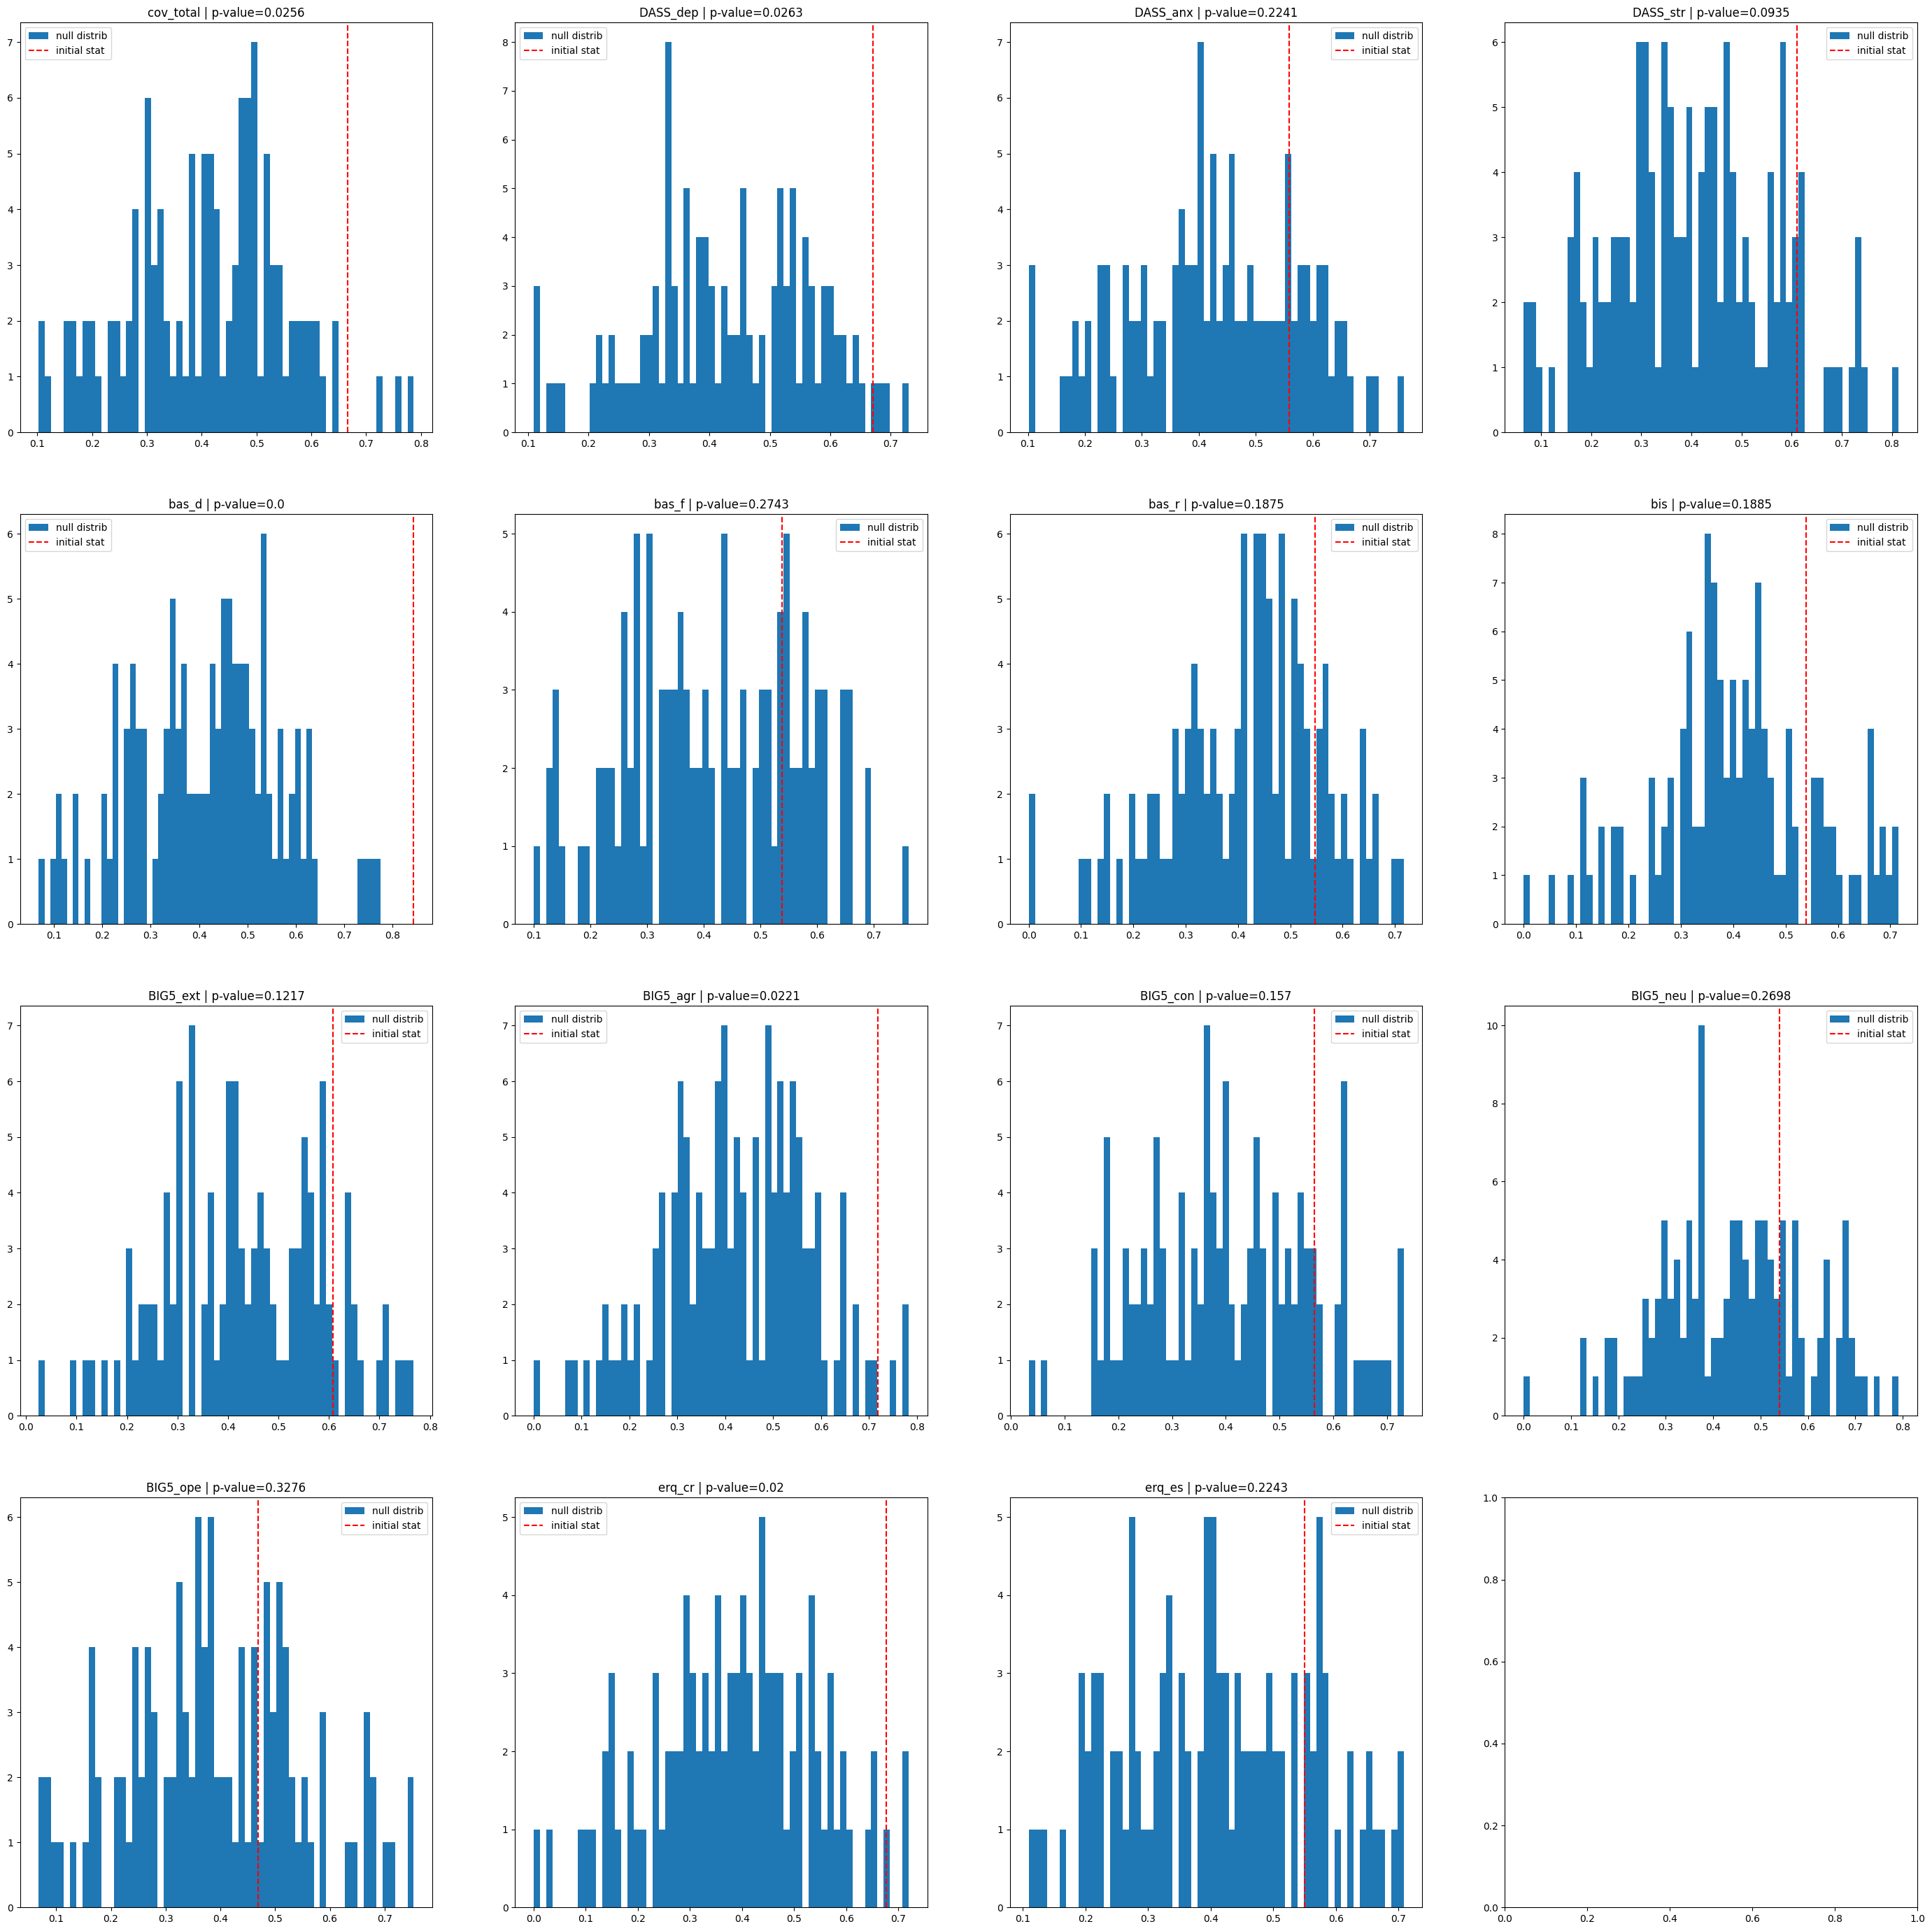

In [40]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

pvalues_movie = {}
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    initial_stat = pred_distrib[pred_distrib.pidx==feat].max()['foldcorr']
    ndistrib     = null_distrib[null_distrib.pidx==feat]['foldcorr']
    nscore       = null_score(ndistrib, initial_stat)
    pvalues_movie[feat]= round(nscore,4)
    
    ax[r,c].hist(ndistrib, 60, label='null distrib')
    ax[r,c].axvline(x = initial_stat, linestyle='--', 
                    color = 'r', label = 'initial stat')
    ax[r,c].legend()
    ax[r,c].set_title(feat + ' | p-value={}'.format(round(nscore,4)))

<AxesSubplot:xlabel='pidx', ylabel='foldcorr'>

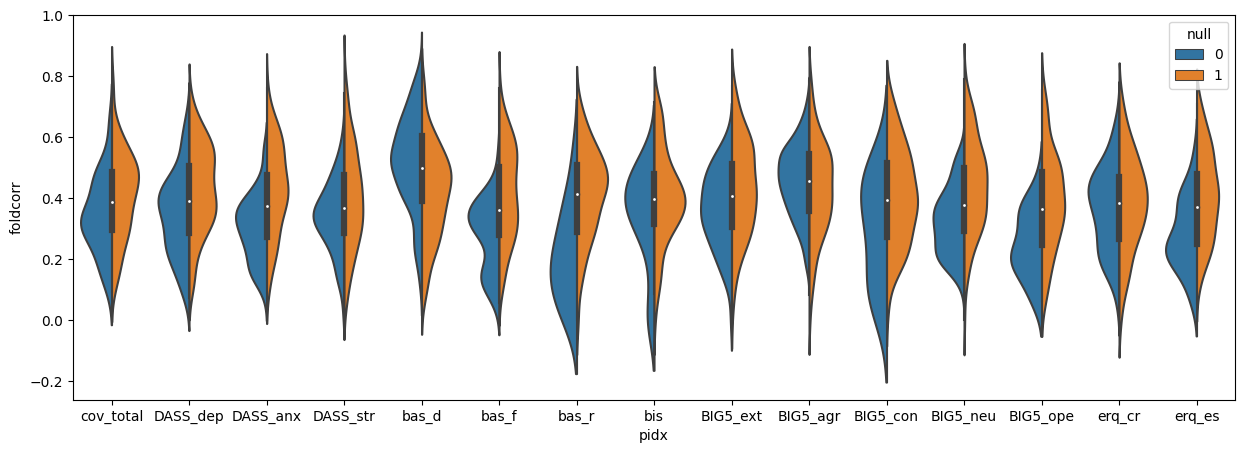

In [110]:
plt.figure(figsize=(15,5))
sns.violinplot(data=pd.concat([pred_distrib, null_distrib]).reset_index(drop=True), 
                x="pidx", y="foldcorr", hue="null", split=True)

##### With Rest

In [41]:
lbd,rbd = -5,1
lambdas_lasso = np.logspace(lbd,rbd,20)

In [42]:
np.random.seed(10)

logs_rest     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull_rest = {existing_psy[i]: [] for i in range(len(existing_psy))}
A        = gradients_rest.reshape(30,-1)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, metric='R2', rd_state=i)
    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logs_rest[feat]  = best_res, best_coeffs, best_corrs

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, null=True, metric='R2', rd_state=i)

    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logsnull_rest[feat] = best_res, best_coeffs, best_corrs

  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
row = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r', 
        'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row:
    folds = logs_rest[r][0]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(folds)
    
    foldsN = logsnull_rest[r][0]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(foldsN)
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx'] += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx'] += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)

In [44]:
pred_distrib['null'] = 0
null_distrib['null'] = 1

Text(0.5, 1.0, 'Rest gradients personality prediction')

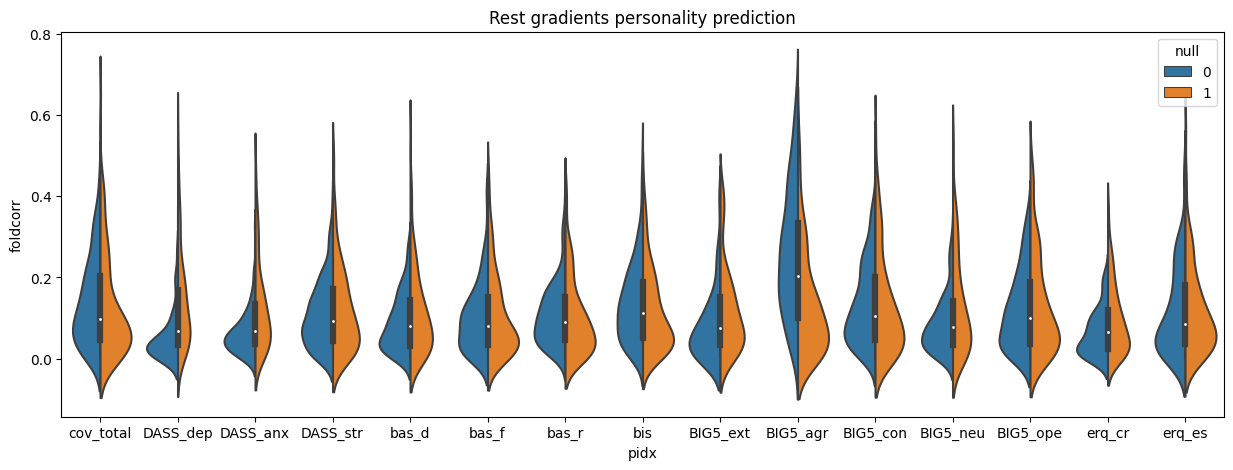

In [178]:
plt.figure(figsize=(15,5))
sns.violinplot(data=pd.concat([pred_distrib, null_distrib]).reset_index(drop=True), 
                x="pidx", y="foldcorr", hue="null", split=True)
plt.title('Rest gradients personality prediction')

  0%|          | 0/15 [00:00<?, ?it/s]

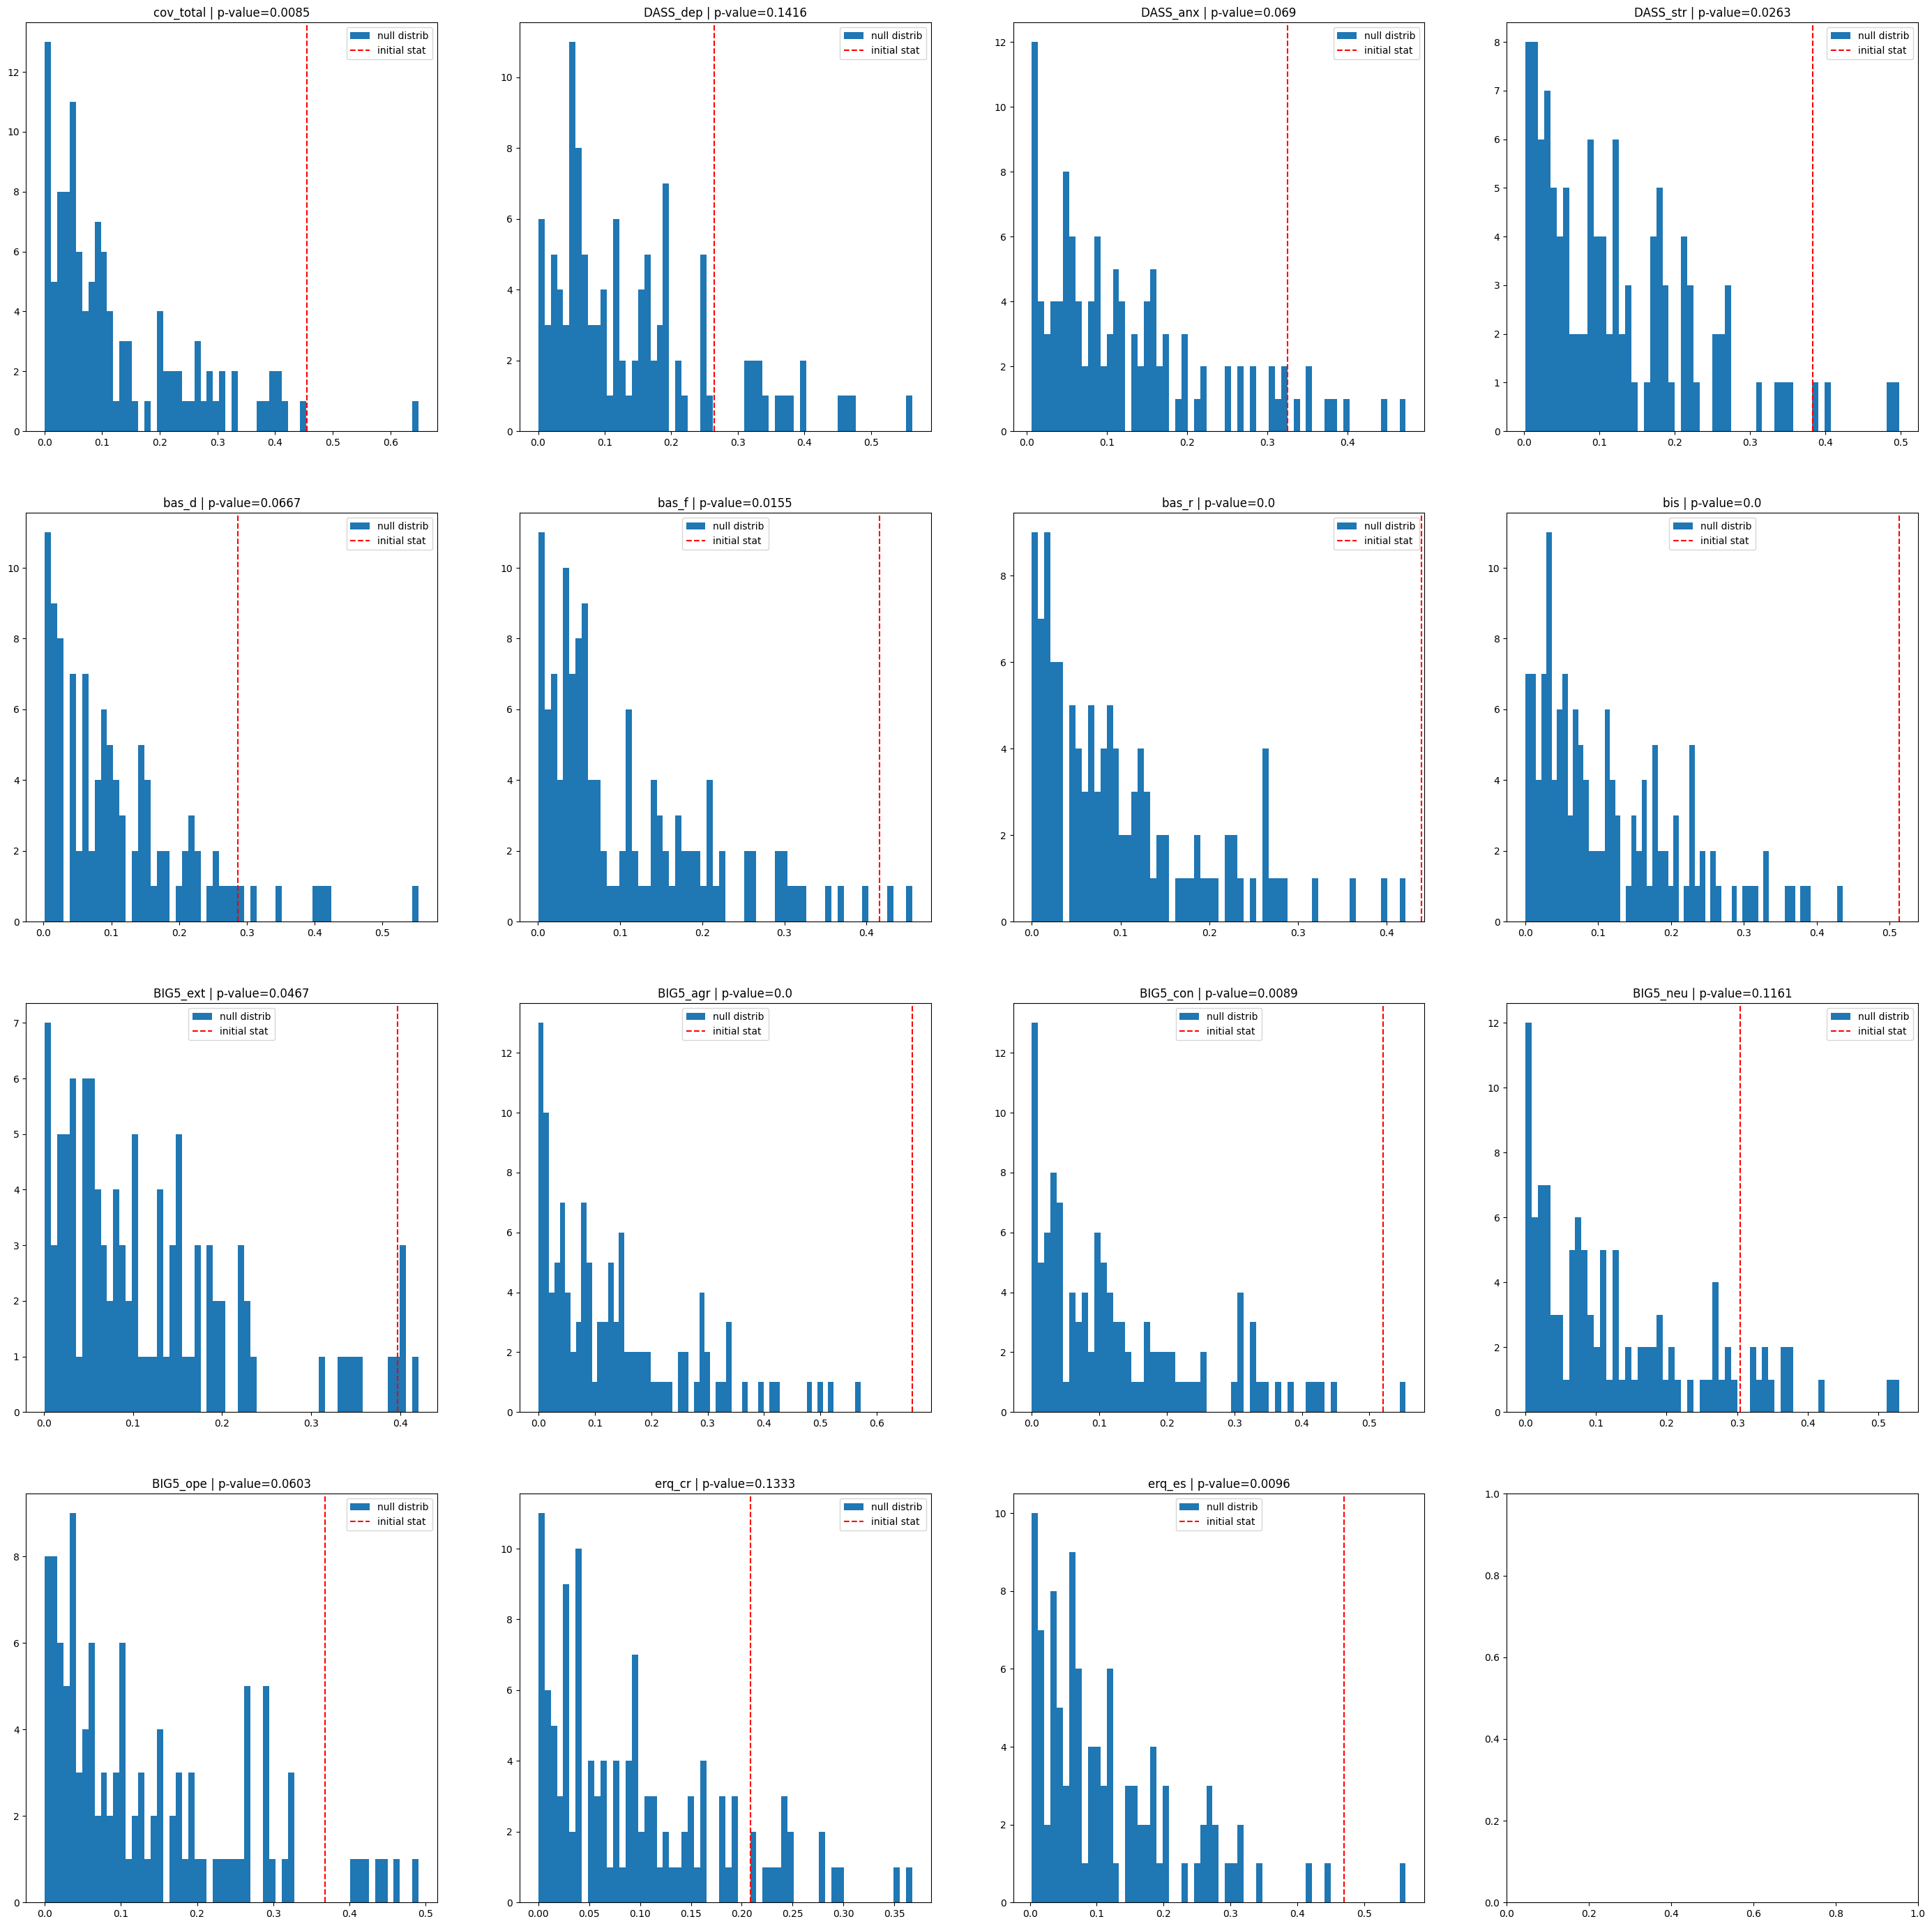

In [45]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

pvalues_rest = {}
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    initial_stat = pred_distrib[pred_distrib.pidx==feat].max()['foldcorr']
    ndistrib     = null_distrib[null_distrib.pidx==feat]['foldcorr']
    nscore       = null_score(ndistrib, initial_stat)
    pvalues_rest[feat]= round(nscore,4)
    
    ax[r,c].hist(ndistrib, 60, label='null distrib')
    ax[r,c].axvline(x = initial_stat, linestyle='--', 
                    color = 'r', label = 'initial stat')
    ax[r,c].legend()
    ax[r,c].set_title(feat + ' | p-value={}'.format(round(nscore,4)))

In [46]:
pvalues = {}
for k in pvalues_movie.keys():
    tmp1, tmp2 = pvalues_movie[k], pvalues_rest[k]
    pvalues[k] = [tmp1,tmp2]

In [51]:
tmp = pd.DataFrame.from_dict(pvalues)

In [57]:
tmp.index = ['film', 'rest']

In [61]:
print(tmp.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  cov\_total &  DASS\_dep &  DASS\_anx &  DASS\_str &   bas\_d &   bas\_f &   bas\_r &     bis &  BIG5\_ext &  BIG5\_agr &  BIG5\_con &  BIG5\_neu &  BIG5\_ope &  erq\_cr &  erq\_es \\
\midrule
film &     0.0256 &    0.0263 &    0.2241 &    0.0935 &  0.0000 &  0.2743 &  0.1875 &  0.1885 &    0.1217 &    0.0221 &    0.1570 &    0.2698 &    0.3276 &  0.0200 &  0.2243 \\
rest &     0.0085 &    0.1416 &    0.0690 &    0.0263 &  0.0667 &  0.0155 &  0.0000 &  0.0000 &    0.0467 &    0.0000 &    0.0089 &    0.1161 &    0.0603 &  0.1333 &  0.0096 \\
\bottomrule
\end{tabular}



#### Ridge on Features Full Gradients (3 Gradients) with K-Fold

In [122]:
lambdas_ridge = np.logspace(0,3,20)

In [123]:
np.random.seed(10)

logs     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull = {existing_psy[i]: [] for i in range(len(existing_psy))}
A        = gradients_rest.reshape(30,-1)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = fold_predict(Ridge, lambdas_ridge, A, psyscore, 5, 200)
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))    
    logs[feat]  = best_corrs, best_coeffs

    corr_coef   = fold_predict(Ridge, lambdas_ridge, A, psyscore, 5, 200, null=True)
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    logsnull[feat] = best_corrs, best_coeffs

100%|██████████| 15/15 [05:27<00:00, 21.86s/it]


In [124]:
row1 = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r']
row2 = ['bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row1:
    folds = logs[r][0]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(np.nanmean(folds, axis=1))
    
    foldsN = logsnull[r][0]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(np.nanmean(foldsN, axis=1))
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx'] += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx'] += len(foldsN) * [r]


pred_distrib2 = {'pidx': [], 'foldcorr': []}
null_distrib2 = {'pidx': [], 'foldcorr': []}
for r in row2:
    folds = logs[r][0]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(np.nanmean(folds, axis=1))
    
    foldsN = logsnull[r][0]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(np.nanmean(foldsN, axis=1))
    
    pred_distrib2['foldcorr'] += list(folds)
    pred_distrib2['pidx'] += len(folds) * [r]
    null_distrib2['foldcorr'] += list(foldsN)
    null_distrib2['pidx'] += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)
pred_distrib2 = pd.DataFrame.from_dict(pred_distrib2)
null_distrib2 = pd.DataFrame.from_dict(null_distrib2)

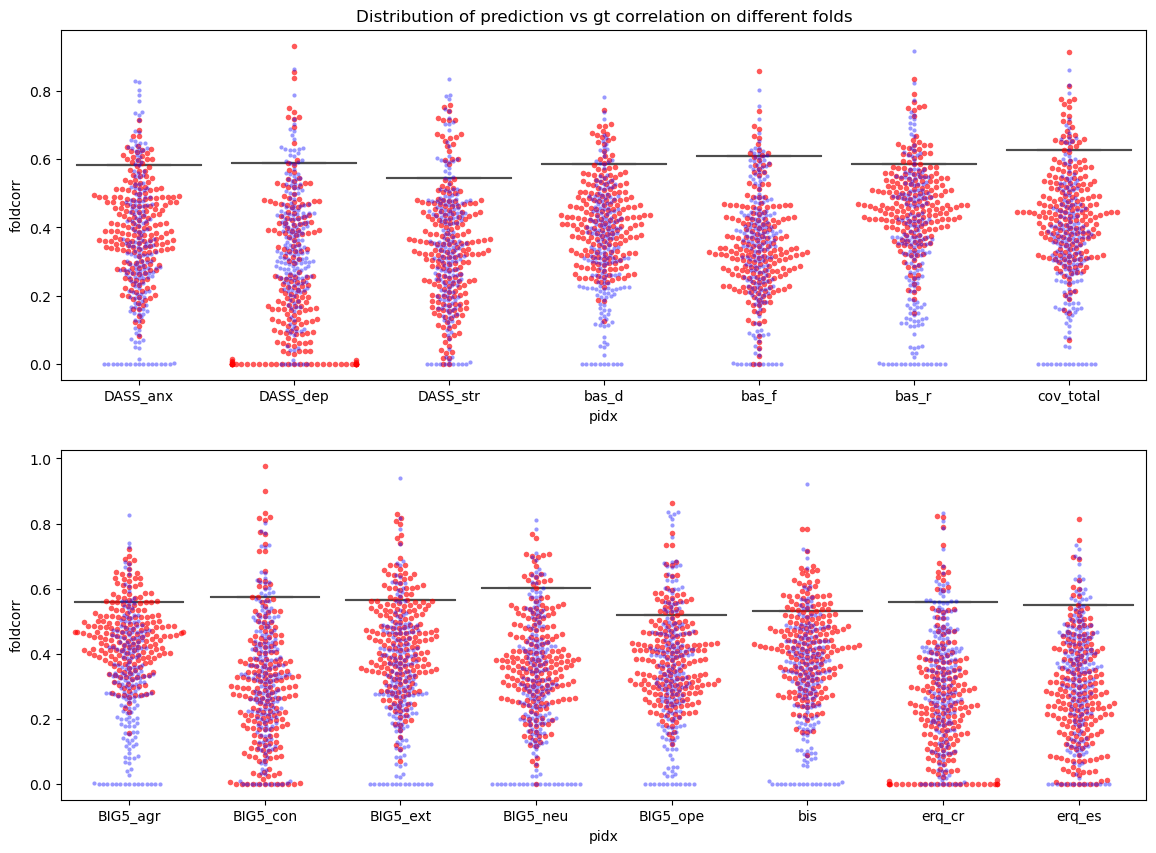

In [126]:
pal = sns.color_palette('hsv', len(row1))
fig, ax = plt.subplots(2,1,figsize=(14,10))

# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib, capsize=0.001, errorbar="sd", palette=pal, alpha=0.3)
sns.boxplot(ax=ax[0], x="pidx", y="foldcorr", data=null_distrib.groupby('pidx').quantile(0.90).reset_index(), palette=pal)
sns.swarmplot(ax=ax[0],x="pidx", y="foldcorr", data=pred_distrib, color="r", alpha=.65, size=4)
sns.swarmplot(ax=ax[0], x="pidx", y="foldcorr", data=null_distrib, color="b", alpha=.4, size=3)

sns.boxplot(ax=ax[1],x="pidx", y="foldcorr", data=null_distrib2.groupby('pidx').quantile(0.90).reset_index(), palette=pal)
sns.swarmplot(ax=ax[1],x="pidx", y="foldcorr", data=pred_distrib2, color="r", alpha=.65, size=4)
sns.swarmplot(ax=ax[1],x="pidx", y="foldcorr", data=null_distrib2, color="b", alpha=.4, size=3)

ax[0].set_title("Distribution of prediction vs gt correlation on different folds")
plt.show()

#### Ridge on Features (volume of each network)

In [110]:
networks      = list(index2region.keys())
lambdas_ridge = [10**i for i in range(5)]

In [112]:
np.random.seed(10)

logs     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull = {existing_psy[i]: [] for i in range(len(existing_psy))}

A = np.zeros((30,len(networks)))
for p in range(30):
    for nidx, n in enumerate(networks):
        A[p,nidx] = network_volume(gradients_rest[p], n)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = fold_predict(Ridge, lambdas_ridge, A, psyscore, 5, 200)
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))    
    logs[feat]  = best_corrs, best_coeffs

    corr_coef   = fold_predict(Ridge, lambdas_ridge, A, psyscore, 5, 200, null=True)
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    logsnull[feat] = best_corrs, best_coeffs    

100%|██████████| 15/15 [00:40<00:00,  2.72s/it]


In [113]:
row1 = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r']
row2 = ['bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row1:
    folds = logs[r][0]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(np.nanmean(folds, axis=1))
    
    foldsN = logsnull[r][0]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(np.nanmean(foldsN, axis=1))
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx'] += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx'] += len(foldsN) * [r]


pred_distrib2 = {'pidx': [], 'foldcorr': []}
null_distrib2 = {'pidx': [], 'foldcorr': []}
for r in row2:
    folds = logs[r][0]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(np.nanmean(folds, axis=1))
    
    foldsN = logsnull[r][0]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(np.nanmean(foldsN, axis=1))
    
    pred_distrib2['foldcorr'] += list(folds)
    pred_distrib2['pidx'] += len(folds) * [r]
    null_distrib2['foldcorr'] += list(foldsN)
    null_distrib2['pidx'] += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)
pred_distrib2 = pd.DataFrame.from_dict(pred_distrib2)
null_distrib2 = pd.DataFrame.from_dict(null_distrib2)

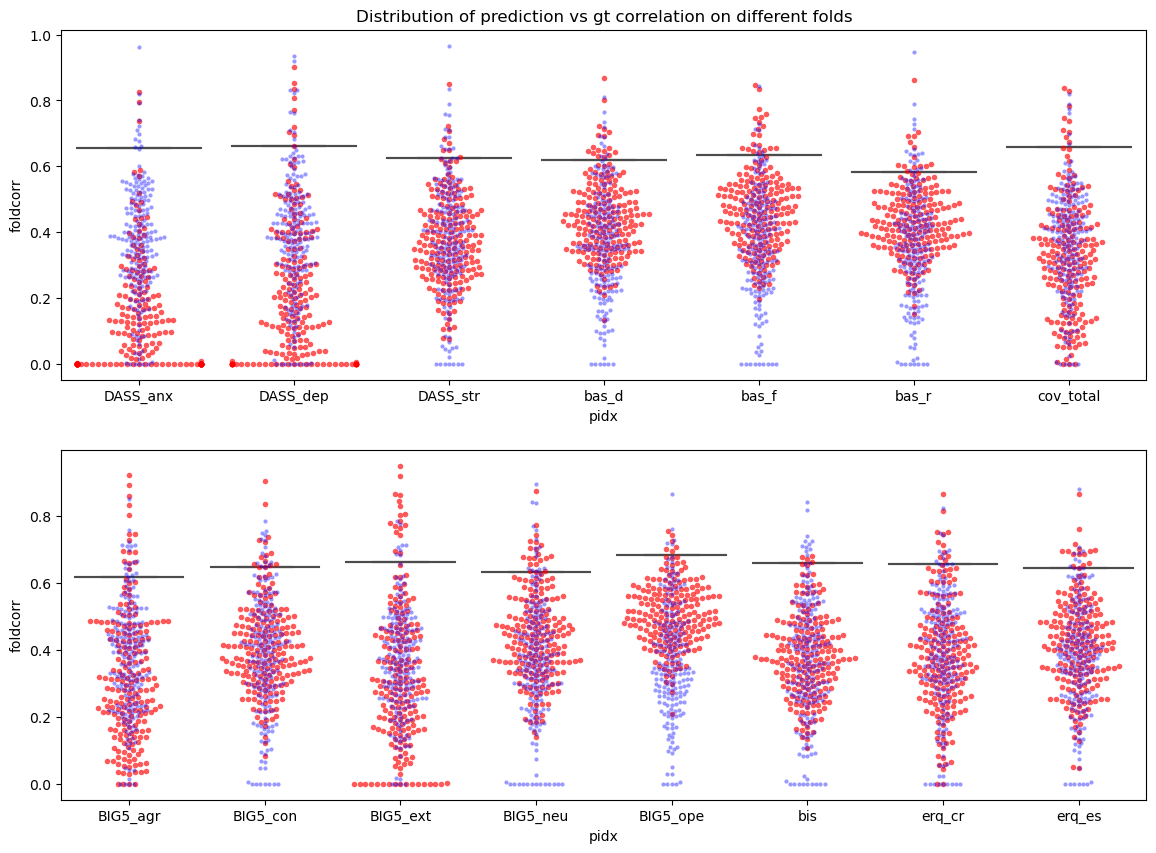

In [114]:
pal = sns.color_palette('hsv', len(row1))
fig, ax = plt.subplots(2,1,figsize=(14,10))

# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib, capsize=0.001, errorbar="sd", palette=pal, alpha=0.3)
sns.boxplot(ax=ax[0], x="pidx", y="foldcorr", data=null_distrib.groupby('pidx').quantile(0.95).reset_index(), palette=pal)
sns.swarmplot(ax=ax[0],x="pidx", y="foldcorr", data=pred_distrib, color="r", alpha=.65, size=4)
sns.swarmplot(ax=ax[0], x="pidx", y="foldcorr", data=null_distrib, color="b", alpha=.4, size=3)

sns.boxplot(ax=ax[1],x="pidx", y="foldcorr", data=null_distrib2.groupby('pidx').quantile(0.95).reset_index(), palette=pal)
sns.swarmplot(ax=ax[1],x="pidx", y="foldcorr", data=pred_distrib2, color="r", alpha=.65, size=4)
sns.swarmplot(ax=ax[1],x="pidx", y="foldcorr", data=null_distrib2, color="b", alpha=.4, size=3)

ax[0].set_title("Distribution of prediction vs gt correlation on different folds")
plt.show()

#### Ridge on Features selected + (shuffling the elements)

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression

A = gradients[:,:,:1].reshape(30,-1)

100%|██████████| 15/15 [02:05<00:00,  8.39s/it]


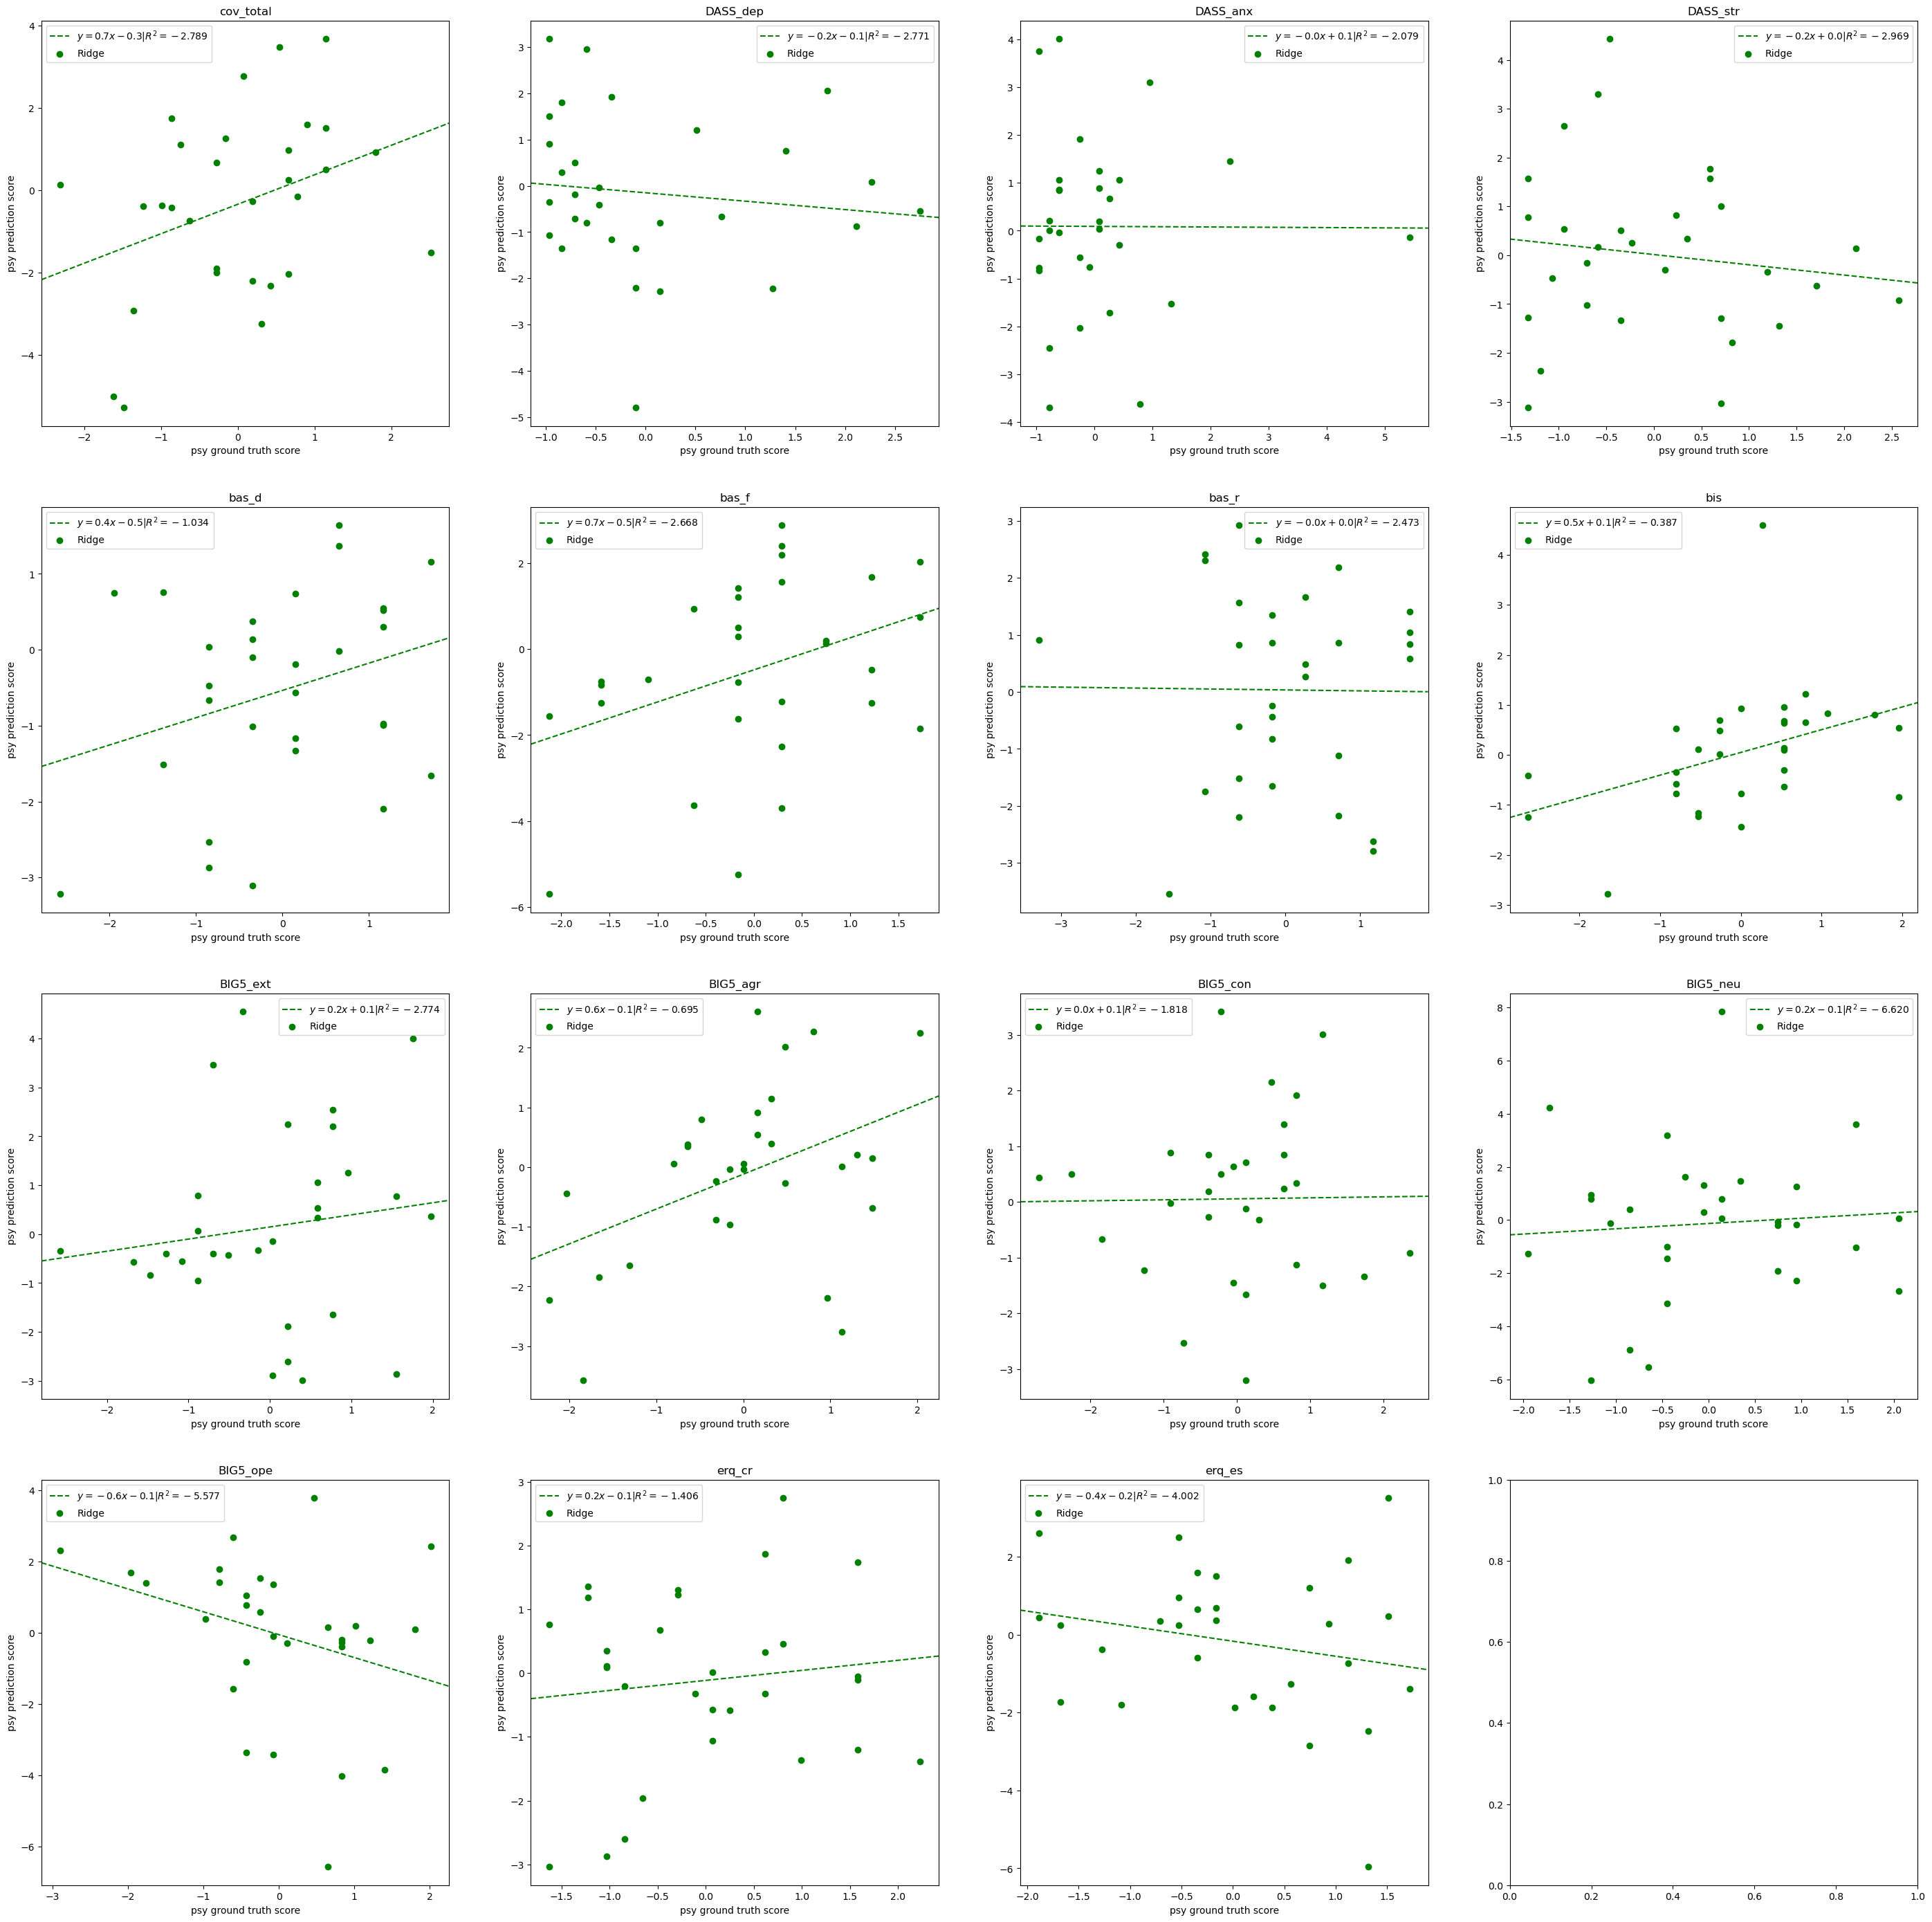

In [12]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

logs = {k: {} for k in existing_psy}

for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    clf  = Ridge(alpha=1.0)

    # leave one out val prediction score    
    pts2 = []
    for i in range(len(psyscore)):
        # select number of percentile
        tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
        tmp2 = np.concatenate([A[:i], A[i+1:]])

        selector = SelectPercentile(mutual_info_regression, percentile=10)
        selector.fit(tmp2, tmp)
        
        newfeatures = A[:,selector.get_support()]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2[:,selector.get_support()], y)

        # we log the coefficients and as well the 
        logs[feat][i] = [selector.get_support(), clf.coef_]

        topredict = newfeatures[i]
        gt = (psyscore[i]-m)/s

        pts2.append([clf.predict([topredict])[0], gt])
        
    pts2 = np.asarray(pts2)

    r2 = r2_score(pts2[:,1],pts2[:,0])
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')

    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")

    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

In [48]:
pindx = 'bas_d'
selected_grads = np.zeros(400)
summed_coefs   = np.zeros(400)
for i in range(len(logs[pindx])):
    selected_grad, coefs = logs[pindx][i]
    selected_grads += selected_grad

    grad = np.zeros_like(selected_grad, dtype=float)
    c    = 0
    for k in range(len(grad)):
        if selected_grad[k] == True:
            grad[k] = np.abs(coefs[c])
            c += 1
    summed_coefs += grad

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


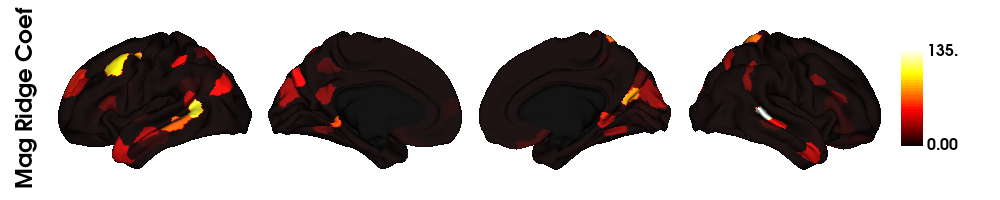

In [49]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

grad_map = map_to_labels(summed_coefs * selected_grads, labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad_map, size=(1000, 200), cmap='hot',
                 color_bar=True, label_text=['Mag Ridge Coef'], zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)


In [37]:
# For best model for ridge / number of features found above 
# We try to shuffle the dataset and refit to see prediction strength

j = 20 # We fix the split to be 20 and split it the same way all the time

C = np.zeros((len(existing_psy), 100))
for i in tqdm(range(len(existing_psy))):
    indices = np.arange(0,30)
    for n in range(20):
        np.random.shuffle(indices)

        k    = psy_k[i]
        feat = existing_psy[i]

        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
        psyscore = np.array(psyscore)

        selector = SelectKBest(mutual_info_regression, k=k)
        selector.fit(A[indices[:j]], psyscore[indices[:j]])
        newfeatures = A[:,selector.get_support()]

        clf  = Ridge(alpha=1)
        tmp  = psyscore[indices[:j]]
        tmp2 = newfeatures[indices[:j]]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = newfeatures[indices[j:]]
        gt   = (psyscore[indices[j:]]-m)/s

        pred2  = clf.predict(topredict)
        corr   = stats.pearsonr(gt, pred2).statistic
        C[i,n] = corr

100%|██████████| 15/15 [02:33<00:00, 10.25s/it]


Test distribution

In [44]:
np.random.seed(99)
distribsA = []
n = len(psyscore)
j = 20
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    selector = SelectKBest(mutual_info_regression, k=psy_k[i])
    selector.fit(A[:j], psyscore[:j])
    newfeatures = A[:,selector.get_support()]    
    
    null_distrib = []
    for _ in range(1000):
        np.random.shuffle(psyscore)

        clf  = Ridge(alpha=1)
        tmp  = psyscore[:j]
        tmp2 = newfeatures[:j]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = newfeatures[j:]

        gt = (psyscore[j:]-m)/s
    
        pred = clf.predict(topredict)
        corr   = stats.pearsonr(pred, gt).statistic
        null_distrib.append(corr)
    distribsA.append(null_distrib)

100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


### Regression with PCA featured on train

In [52]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad.pkl')
subjects     = list(subject_grad.keys())
gradients = np.asarray([subject_grad[s] for s in subjects])

In [53]:
from sklearn.decomposition import PCA

100%|██████████| 15/15 [03:03<00:00, 12.22s/it]


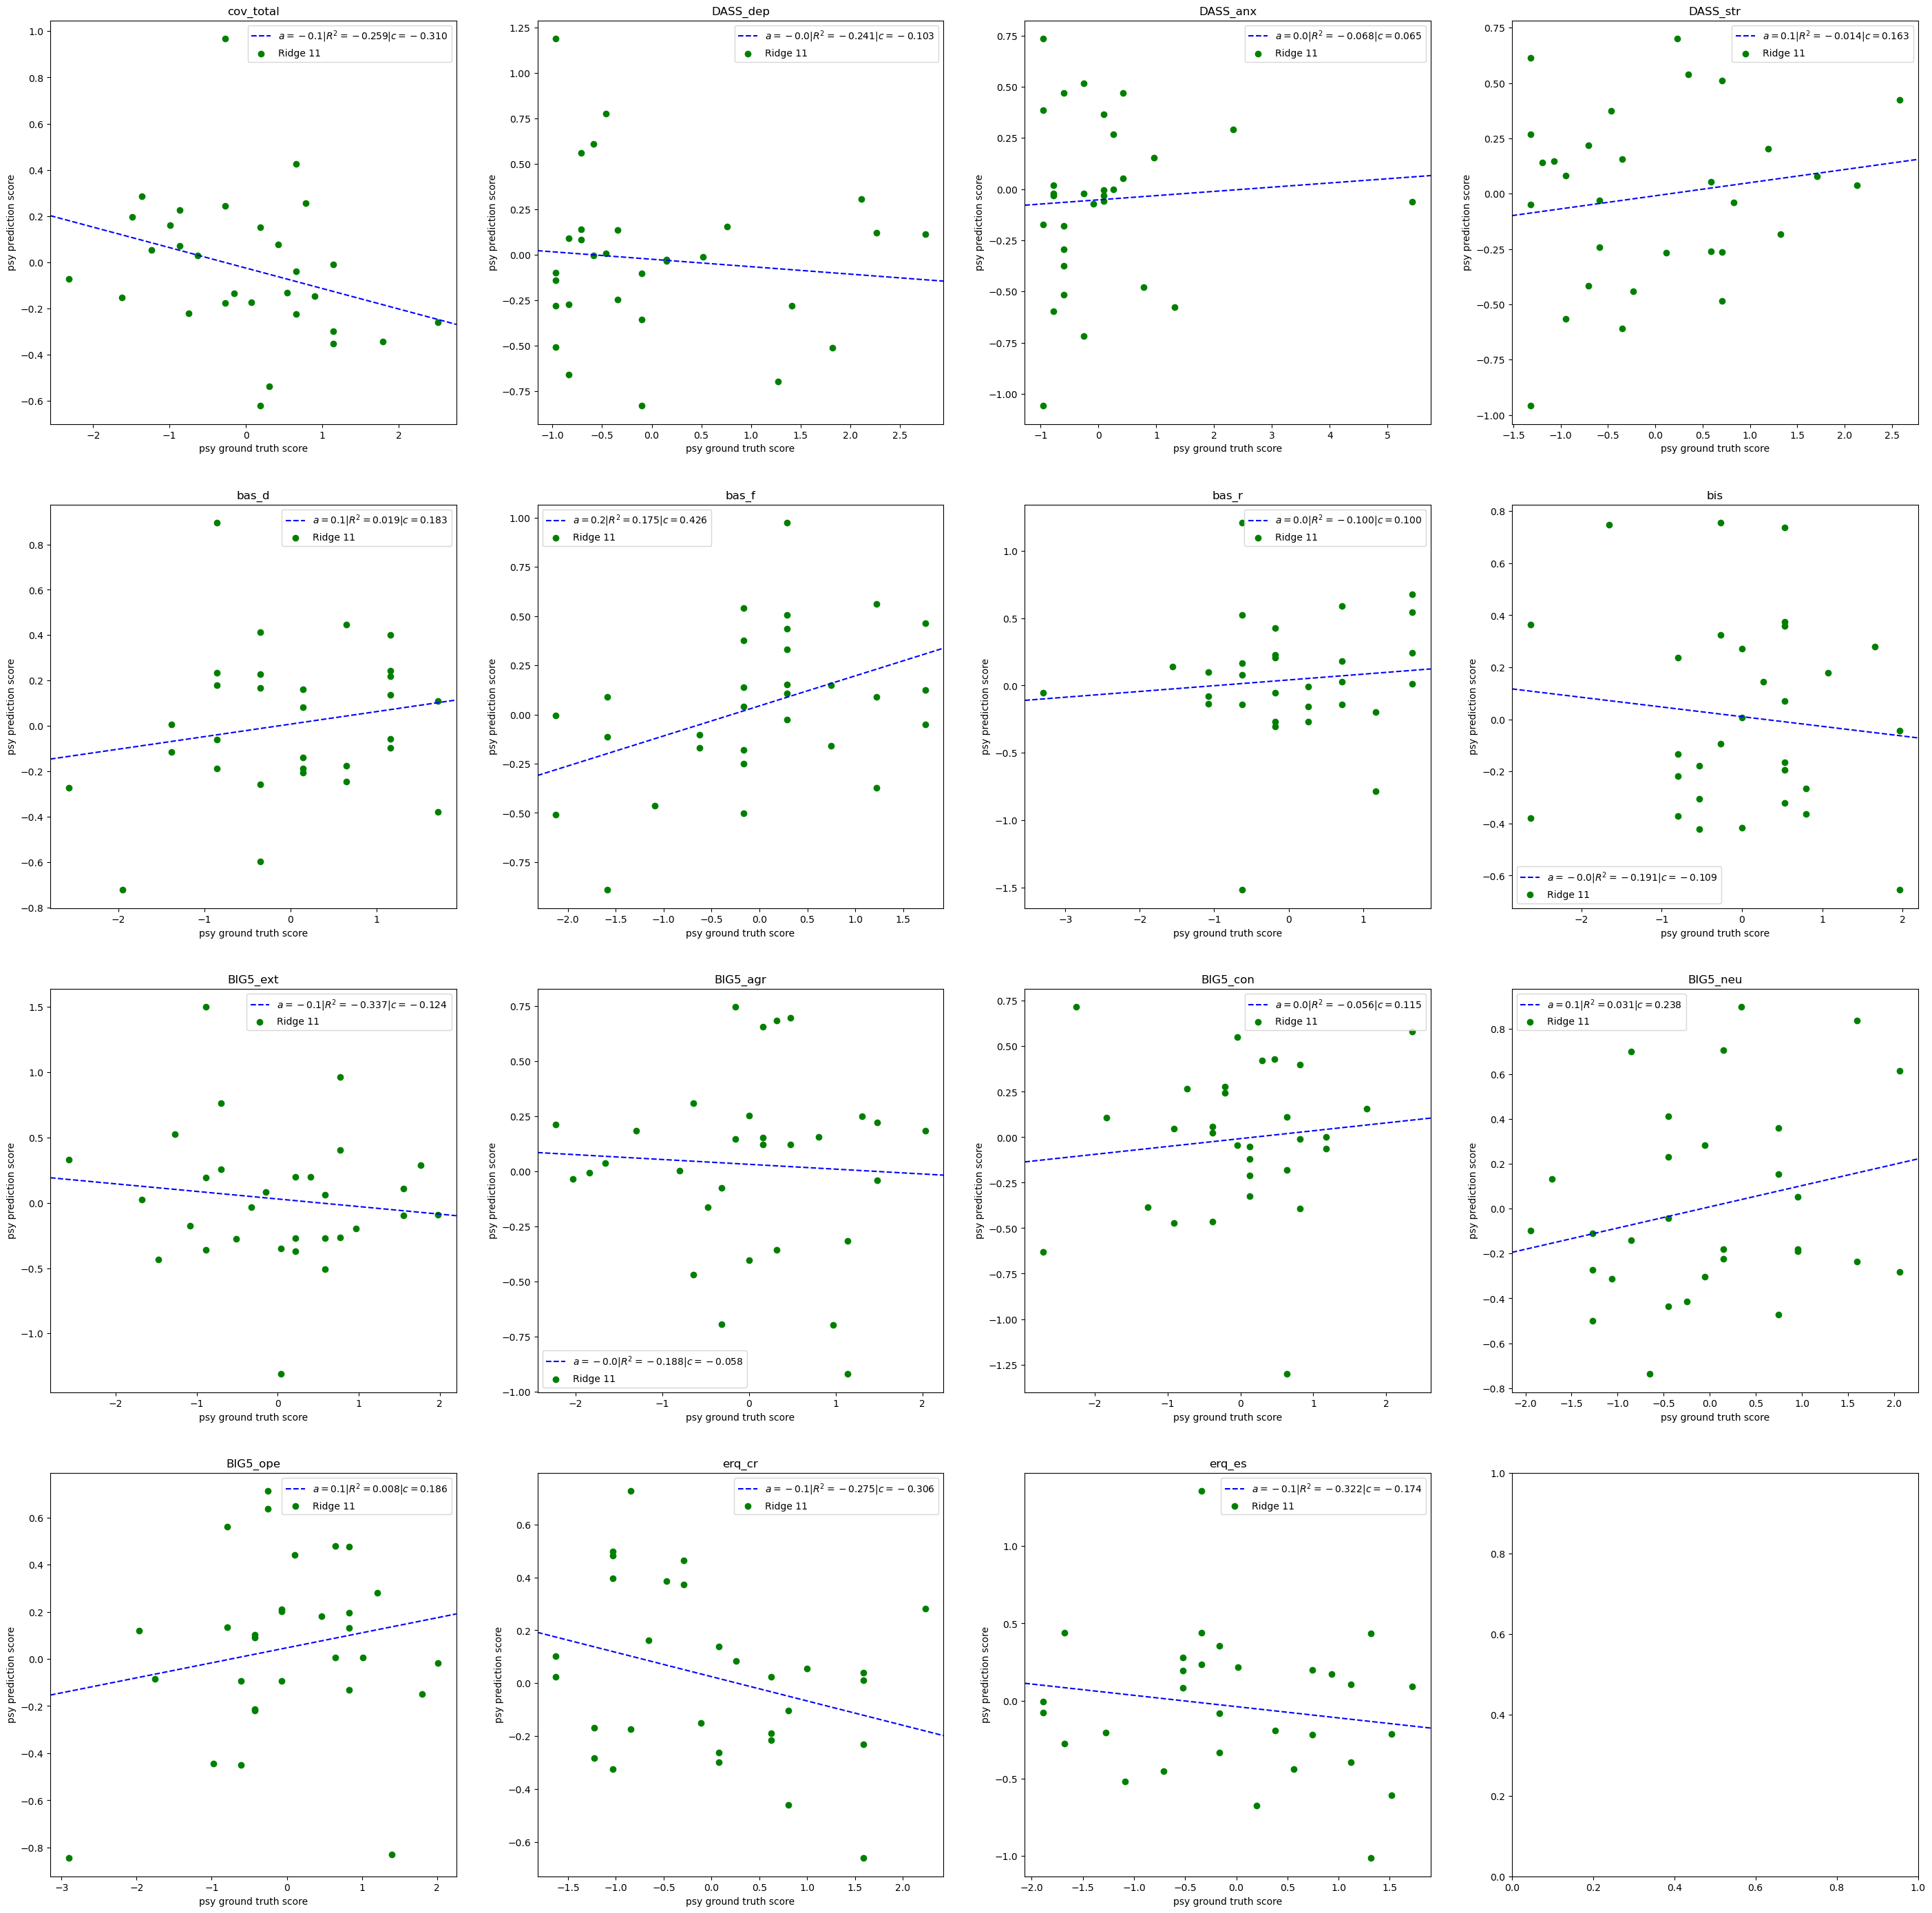

In [65]:
logs  = {}
lambdas = [0.5,1] +[i/10 for i in range(10,31,1)]
A     = gradients.reshape(30,-1)
fig, ax = plt.subplots(4,4, figsize=(35,35))


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    psyscore = np.array(psyscore)

    best_corr = -1
    pts = []
    for a in lambdas:
        clf  = Ridge(alpha=a)
        # leave one out val prediction score    
        pts2 = []
        for j in range(len(psyscore)):
            ncomb    = 10
            cur_expl = 0
            # select number of percentile
            tmp  = np.concatenate([psyscore[:j], psyscore[j+1:]])
            tmp2 = np.concatenate([A[:j], A[j+1:]])

            while cur_expl < 0.8:
                pca  = PCA(n_components=ncomb)
                pca.fit(tmp2)
                cur_expl = np.sum(pca.explained_variance_ratio_)
                ncomb += 1
            tmp2 = pca.transform(tmp2)

            y, m, s = zscore(tmp, ret_param=True)
            clf.fit(tmp2, y)

            topredict = pca.transform([A[j]])
            gt = (psyscore[j]-m)/s

            pts2.append([clf.predict(topredict)[0], gt])
            
        pts2 = np.asarray(pts2)

        cur_corr   = stats.pearsonr(pts2[:,0], pts2[:,1]).statistic
        if cur_corr > best_corr:
            best_corr = cur_corr
            pts = deepcopy(pts2)
            logs[feat] = clf.coef_

        # we log the coefficients and as well the 
        
    r2 = r2_score(pts[:,1],pts[:,0])
    m2, b2 = np.polyfit(pts[:,1], pts[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={best_corr:.3f}$', color='b')

    ax[r,c].scatter(pts[:,1], pts[:,0], color='g', label="Ridge {}".format(np.sum(logs[feat] != 0)))

    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

### Mix prediction with movies 

In [118]:
import warnings
warnings.filterwarnings("ignore")

In [126]:
np.random.seed(10)
movies = os.listdir('./resources/static_grad/individual_level/')
feat   = existing_psy[7]

corrs = []
for _ in tqdm(range(1000)):
    trainmovie = np.random.choice(movies, 10, replace=False)
    valmovie   = list(set(movies) - set(trainmovie))
    trainsubjects = np.random.choice(list(subject_grad.keys()), 20, replace=False)
    valsubjects   = list(set(list(subject_grad.keys())) - set(trainsubjects))

    ref = load('./resources/static_grad/group_level/Rest_group_grad.pkl')[:,:2]
    trainData = []
    for mov in trainmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in trainsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in trainsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        trainData   += data

    valData  = []
    for mov in valmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in valsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in valsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        valData     += data

    clf   = Lasso(alpha=1)
    trainY, trainX = np.asarray(trainData).T
    valY, valX     = np.asarray(valData).T

    trainX = np.stack(trainX)
    valX   = np.stack(valX)
    trainY = np.array([behavioural[behavioural.ID == trainY[i]][feat].item() for i in range(len(trainY))])
    valY   = np.array([behavioural[behavioural.ID == valY[i]][feat].item() for i in range(len(valY))])

    trainY, m, s = zscore(trainY, ret_param=True)

    valY   = (valY-m)/s

    clf.fit(trainX, trainY)
    pred = clf.predict(valX)
    corr = stats.pearsonr(pred, valY).statistic
    corrs.append(corr)


100%|██████████| 1000/1000 [01:51<00:00,  8.98it/s]


In [127]:
np.random.seed(10)
movies = os.listdir('./resources/static_grad/individual_level/')
feat   = existing_psy[7]

nullcorrs = []
for _ in tqdm(range(1000)):
    trainmovie = np.random.choice(movies, 10, replace=False)
    valmovie   = list(set(movies) - set(trainmovie))
    trainsubjects = np.random.choice(list(subject_grad.keys()), 20, replace=False)
    valsubjects   = list(set(list(subject_grad.keys())) - set(trainsubjects))

    ref = load('./resources/static_grad/group_level/Rest_group_grad.pkl')[:,:2]
    trainData = []
    for mov in trainmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in trainsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in trainsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        trainData   += data

    valData  = []
    for mov in valmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in valsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in valsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        valData     += data

    clf   = Lasso(alpha=1)
    trainY, trainX = np.asarray(trainData).T
    valY, valX     = np.asarray(valData).T

    trainX = np.stack(trainX)
    valX   = np.stack(valX)
    trainY = np.array([behavioural[behavioural.ID == trainY[i]][feat].item() for i in range(len(trainY))])
    valY   = np.array([behavioural[behavioural.ID == valY[i]][feat].item() for i in range(len(valY))])
    np.random.shuffle(trainY)
    np.random.shuffle(valY)

    trainY, m, s = zscore(trainY, ret_param=True)

    valY   = (valY-m)/s

    clf.fit(trainX, trainY)
    pred = clf.predict(valX)
    corr = stats.pearsonr(pred, valY).statistic
    nullcorrs.append(corr)


100%|██████████| 1000/1000 [01:55<00:00,  8.63it/s]


(array([ 1.,  8., 24., 42., 57., 71., 69., 42., 13.,  6.]),
 array([-0.49896097, -0.40595678, -0.31295258, -0.21994839, -0.1269442 ,
        -0.03394   ,  0.05906419,  0.15206838,  0.24507258,  0.33807677,
         0.43108097]),
 <BarContainer object of 10 artists>)

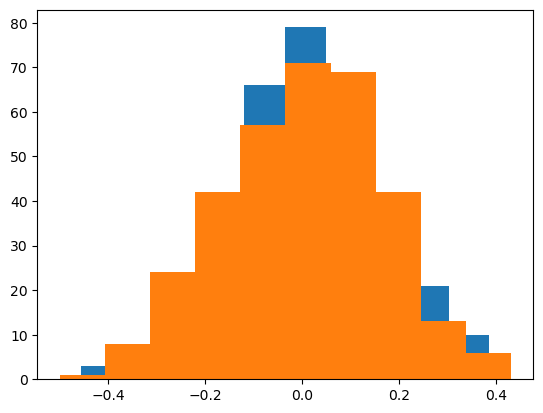

In [129]:
plt.hist(corrs)
plt.hist(nullcorrs)

### Multi-variate ridge

In [114]:
logs = {}
lambdas = [0.5,1] +[i/10 for i in range(10,31,1)]
A = gradients.reshape(30,-1)

pscores = []
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    psyscore = np.array([behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))])
    pscores.append(psyscore)
    # pscores.append(zscore(psyscore))
pscores = np.asarray(pscores)

100%|██████████| 15/15 [00:00<00:00, 63.80it/s]


In [115]:
trainX, valX = A[:20], A[20:]
trainY, valY = pscores.T[:20], pscores.T[20:]

In [118]:
clf  = Lasso(alpha=5)

clf.fit(trainX, trainY)

pred = clf.predict(valX)


100%|██████████| 15/15 [00:00<00:00, 1664.27it/s]


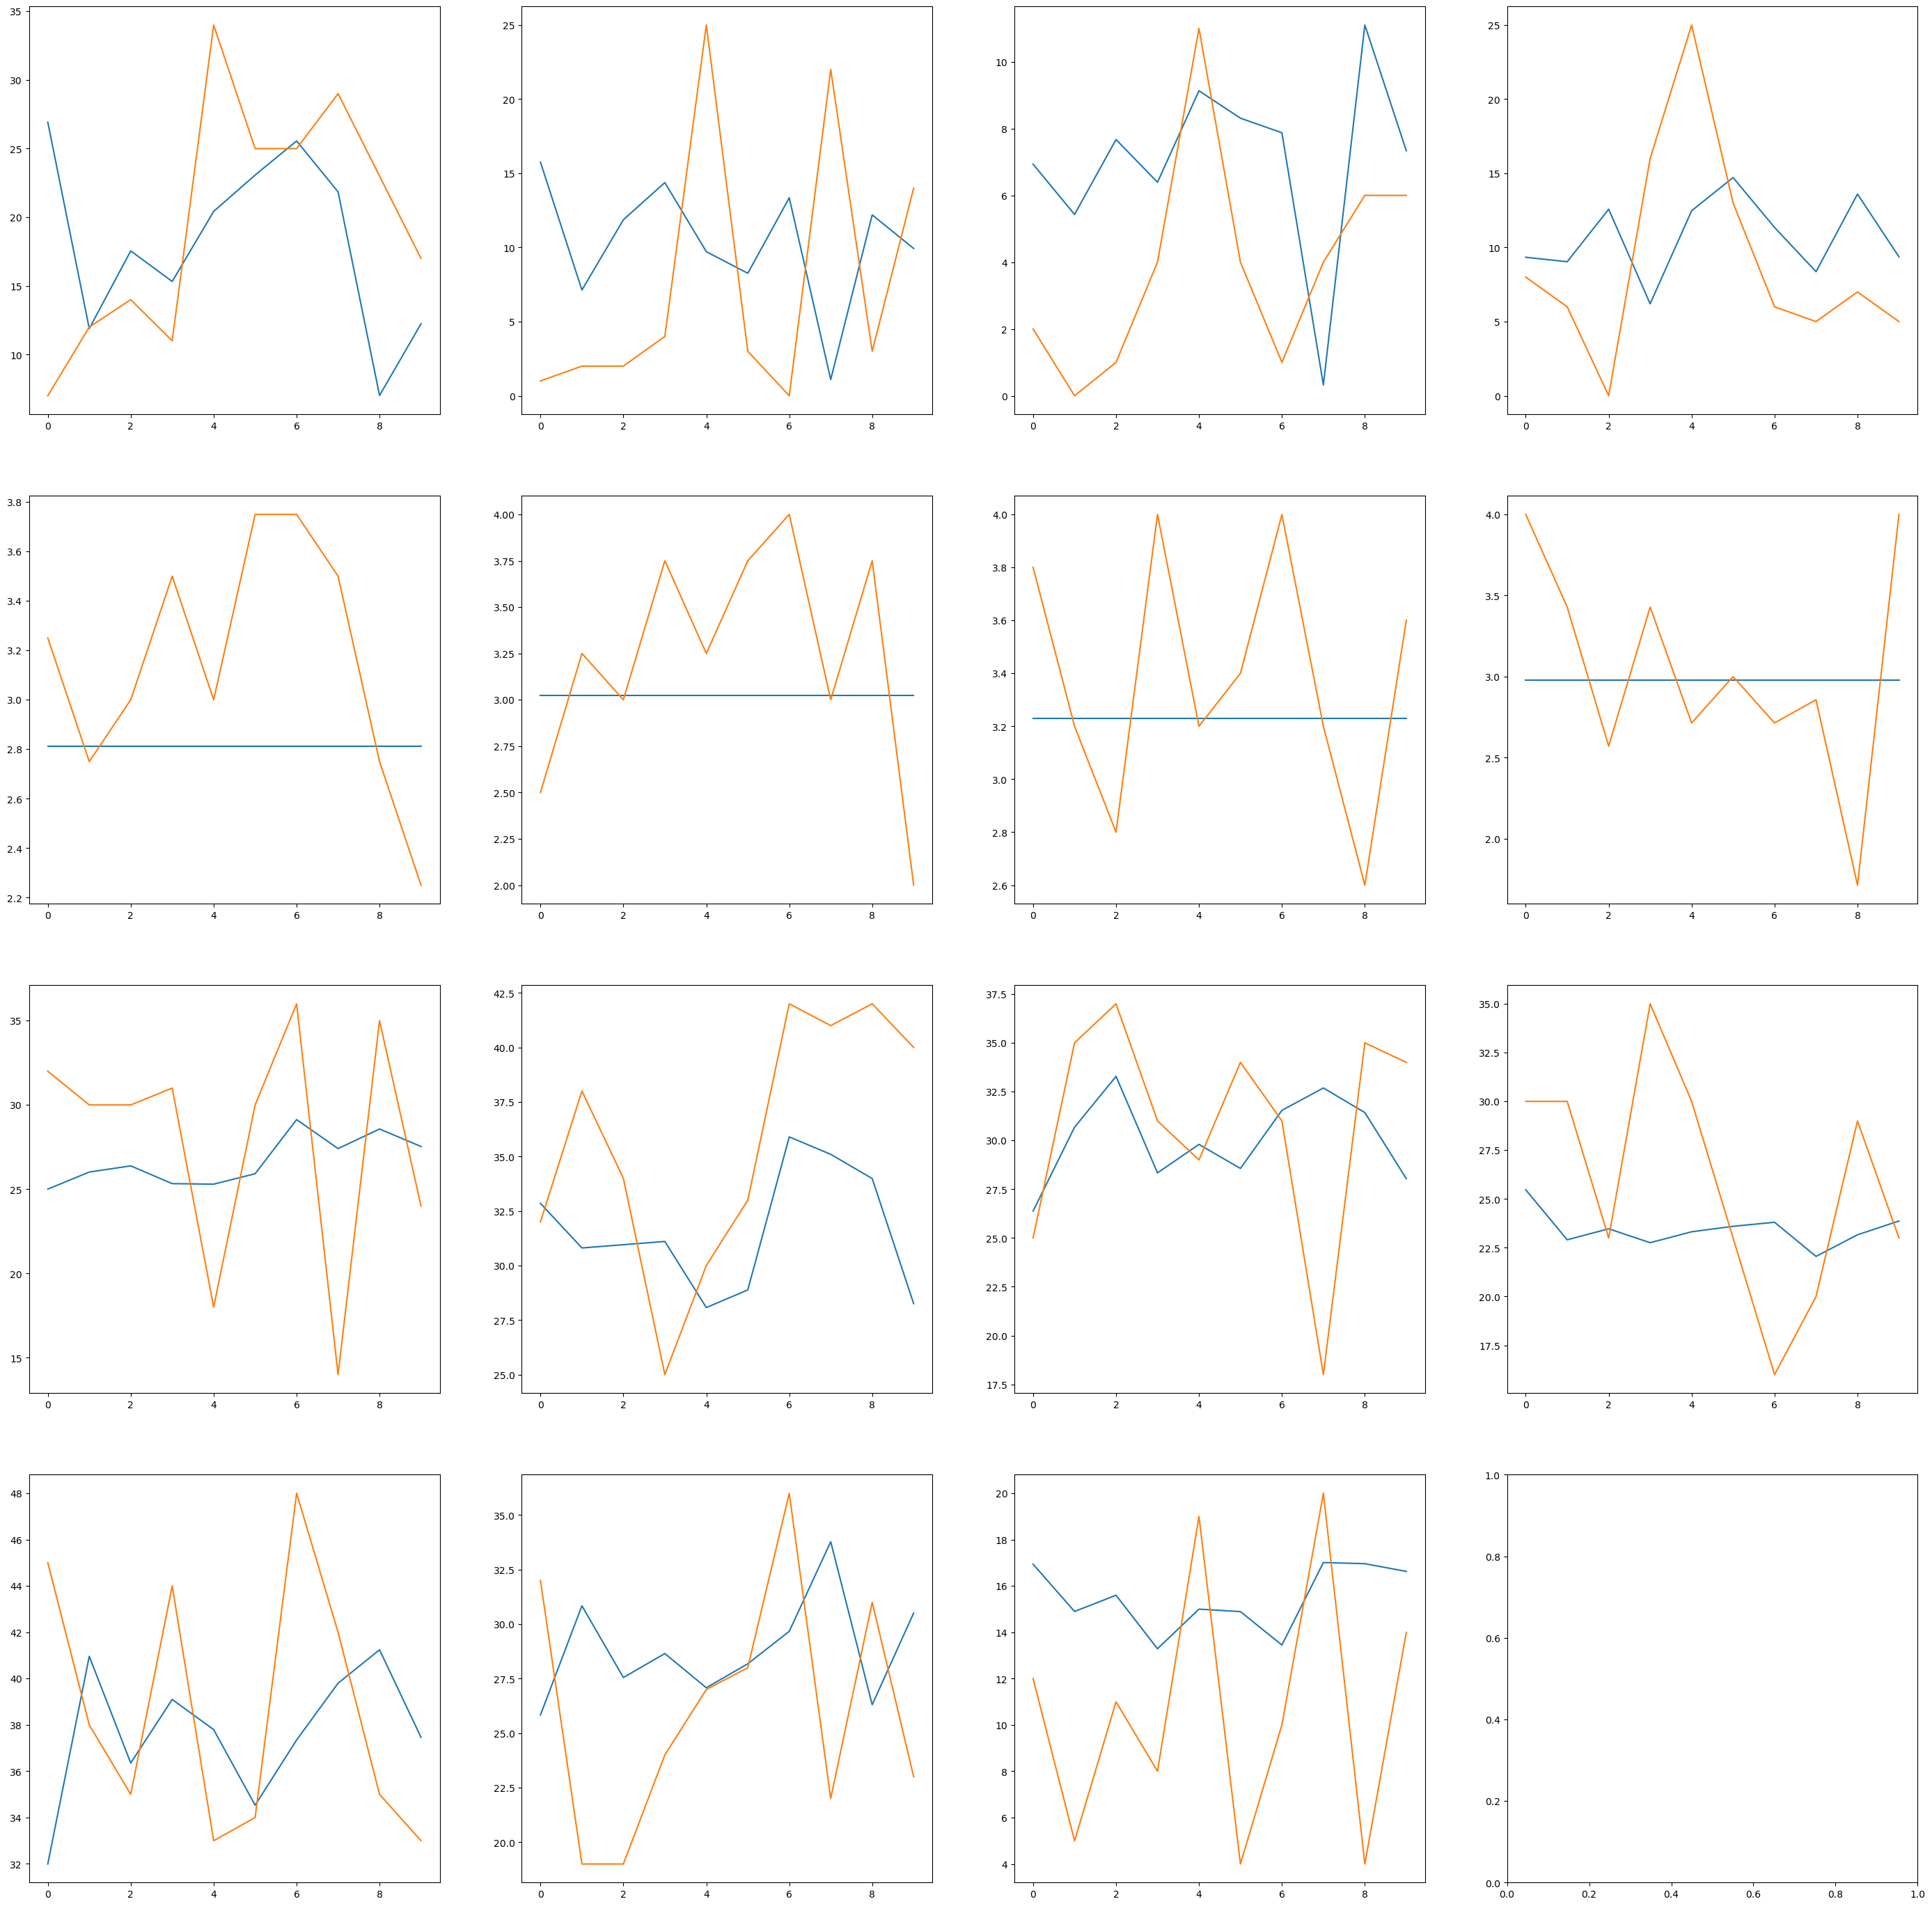

: 

In [119]:
fig, ax = plt.subplots(4,4, figsize=(35,35))


for i in tqdm(range(len(existing_psy))):
    r,c = i //4, i % 4
    ax[r,c].plot(pred[:,i])
    ax[r,c].plot(valY[:,i])